In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])

In [3]:
# Check for stationarity

In [4]:
result = adfuller(ts["Adj Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Non-stationary -> need to differentiate

ADF Statistic: -1.522240
p-value: 0.522482


In [5]:
ts["Close_Diff"] = ts["Adj Close"].diff()

In [6]:
result = adfuller(ts["Close_Diff"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Stationary

ADF Statistic: -11.104181
p-value: 0.000000


/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


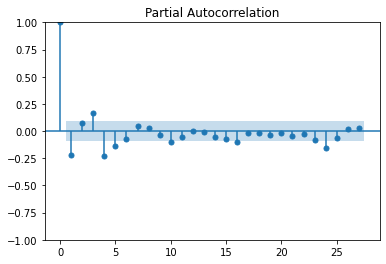

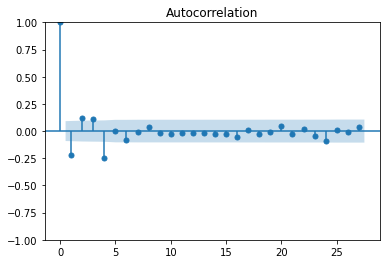

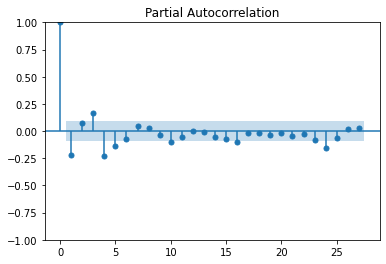

In [7]:
plot_acf(ts.Close_Diff.dropna())
plot_pacf(ts.Close_Diff.dropna())

In [8]:
# Build model and implement rolling window (= ExpandingWindowSplitter) for hyperparameter tuning

In [9]:
# Train, test split
series = ts["Close_Diff"].dropna()
train_size = int(round(len(series) * 0.80, 0))

train = series[:train_size]
y_test = list(series[train_size:])

# Train, val split
train_size2 = int(round(len(train) * 0.80, 0))
y_train = list(train[:train_size2])
y_val = list(train[train_size2:])

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_rolling_forecast(train, val, params):
    history = [x for x in train]
    predictions = list()
    for t in range(len(val)):
        model = ARIMA(history, order=params)
        model_fit = model.fit(return_params=False)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = val[t]
        history.append(obs)
        # print("%d/%d predicted=%f, expected=%f" % (t, len(val), yhat, obs))
    rmse = mean_squared_error(val, predictions, squared = False) # If True returns MSE value, if False returns RMSE value.
    mse = mean_squared_error(val, predictions, squared = True)
    mae = mean_absolute_error(val, predictions)

    return rmse, mse, mae, predictions, val

In [11]:
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

para = [(5,0,0), (1,0,1), (2,0,2), (0,0,5), (1,0,0), (0,0,1), (1, 1, 1), (0, 1, 0), (3, 0, 3)]

In [12]:
history = []
for p in para:
    rmse, mse, mae, _, _ = run_rolling_forecast(y_train, y_val, p)
    s = "Params: " + str(p) + ";RMSE: " + str(rmse) + ";MSE:" + str(mse) + ";MAE:" + str(mae)
    history.append(s)

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [13]:
history

['Params: (5, 0, 0);RMSE: 25.415349038057162;MSE:645.9399667262732;MAE:17.235735778867756',
 'Params: (1, 0, 1);RMSE: 22.624065152014072;MSE:511.84832400257756;MAE:14.741738773348235',
 'Params: (2, 0, 2);RMSE: 28.11670949175778;MSE:790.5493526439021;MAE:18.83111765268434',
 'Params: (0, 0, 5);RMSE: 28.650302851116006;MSE:820.839853460666;MAE:19.500484166394585',
 'Params: (1, 0, 0);RMSE: 22.590215643026074;MSE:510.31784279842;MAE:14.712641505008976',
 'Params: (0, 0, 1);RMSE: 22.227293981354208;MSE:494.052597733545;MAE:14.390676757947777',
 'Params: (1, 1, 1);RMSE: 22.599305724198178;MSE:510.7286192157765;MAE:14.71012874628977',
 'Params: (0, 1, 0);RMSE: 30.265911110772727;MSE:916.025375365196;MAE:19.57753366966771',
 'Params: (3, 0, 3);RMSE: 28.511734015284;MSE:812.9189765583027;MAE:19.2764733230034']

In [14]:
# Save parameters to text file
textfile = open("./eval_model/arima_prediction.txt", "w")
for item in history:
    textfile.write(item + "\n")
textfile.close()

In [15]:
# Save parameters to csv
params = []
rmse = []
mse = []
mae = []
for item in history:
    params.append(item.split(";")[0][8:])
for item in history:
    rmse.append(item.split(";")[1][5:])
for item in history:
    mse.append(item.split(";")[2][4:])
for item in history:
    mae.append(item.split(";")[3][4:])

df = pd.DataFrame({
    "Params": [item for item in params],
    "RMSE": [item for item in rmse],
    "MSE": [item for item in mse],
    "MAE": [item for item in mae]
})

df.to_csv("./eval_model/arima_prediction.csv", sep='\t')

In [16]:
# Hypothetically now, select best later on
best_param = (0, 0, 1)

In [17]:
y_train_final = y_train + y_val

In [18]:
rmse, mse, mae, y_pred, test = run_rolling_forecast(y_train_final, y_test, best_param)

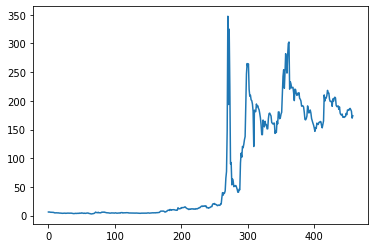

In [19]:
# Plot actual stock price
from matplotlib import pyplot
pyplot.plot(ts["Adj Close"])

In [20]:
# Inverse Diff

In [21]:
def diff_inv(series_diff, first_value):
    series_inverted = list(np.r_[first_value, series_diff].cumsum().astype('float64'))
    return series_inverted

In [22]:
np.array(y_test).cumsum()

array([  0.47000122,   1.08999634,  -8.67999268, -22.13000488,
        -2.1000061 ,  -3.16000366, -10.19000244, -12.99000549,
        -9.25      , -11.61999512,  -8.36000061, -18.13999939,
       -19.66999817, -22.94000244, -31.83999634, -31.11999512,
       -31.27000427, -33.25      , -42.44000244, -54.88000488,
       -55.67999268, -53.46000671, -49.00999451, -31.32000732,
       -36.69000244, -43.6499939 , -42.13999939, -38.55999756,
       -43.96000671, -53.38000488, -57.63999939, -61.38000488,
       -64.8500061 , -69.75      , -75.69999695, -69.05999756,
       -70.72999573, -61.36999512, -63.44999695, -63.72000122,
       -60.1499939 , -59.97999573, -58.57000732, -58.94999695,
       -65.44999695, -69.6000061 , -63.19999695, -57.61000061,
       -12.21000671, -22.8500061 , -17.27999878, -17.55000305,
       -13.30000305,  -4.25999451,  -9.52999878,  -8.97999573,
       -19.75      , -23.5       , -23.69999695, -23.32000732,
       -32.08999634, -19.1000061 , -23.25999451, -17.97

In [23]:
LAST_OBSERVED_VALUE_BEFORE_TEST_SET = ts["Adj Close"][len(y_train_final)]
plt_test = diff_inv(y_test, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)
plt_pred = diff_inv(y_pred, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)
plt_train = diff_inv(y_train, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)

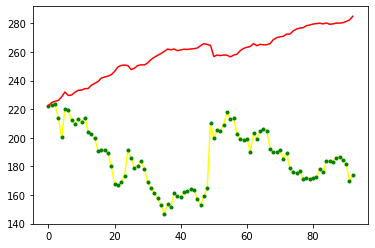

In [24]:
# Plot Price Data
pyplot.plot(ts["Adj Close"].values[len(y_train_final):], '-', color = "yellow")
pyplot.plot(plt_test, '.', color = "green")
pyplot.plot(plt_pred, color = "red")
# Can confirm that the correct last observed value was selected

In [25]:
rmse = mean_squared_error(y_test, plt_test[1:], squared = False)
mse = mean_squared_error(y_test, plt_test[1:], squared = True)
mae = mean_absolute_error(y_test, plt_test[1:])

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 187.2730355409318
MSE: 35071.1898407151
MAE: 186.21858696315599


In [26]:
len(y_train_final)+len(y_pred)

458

In [27]:
len(y_train_final)

366

In [28]:
testPredictPlot = np.empty_like(ts["Adj Close"])
testPredictPlot[:] = np.nan
testPredictPlot[len(y_train_final):] = plt_pred

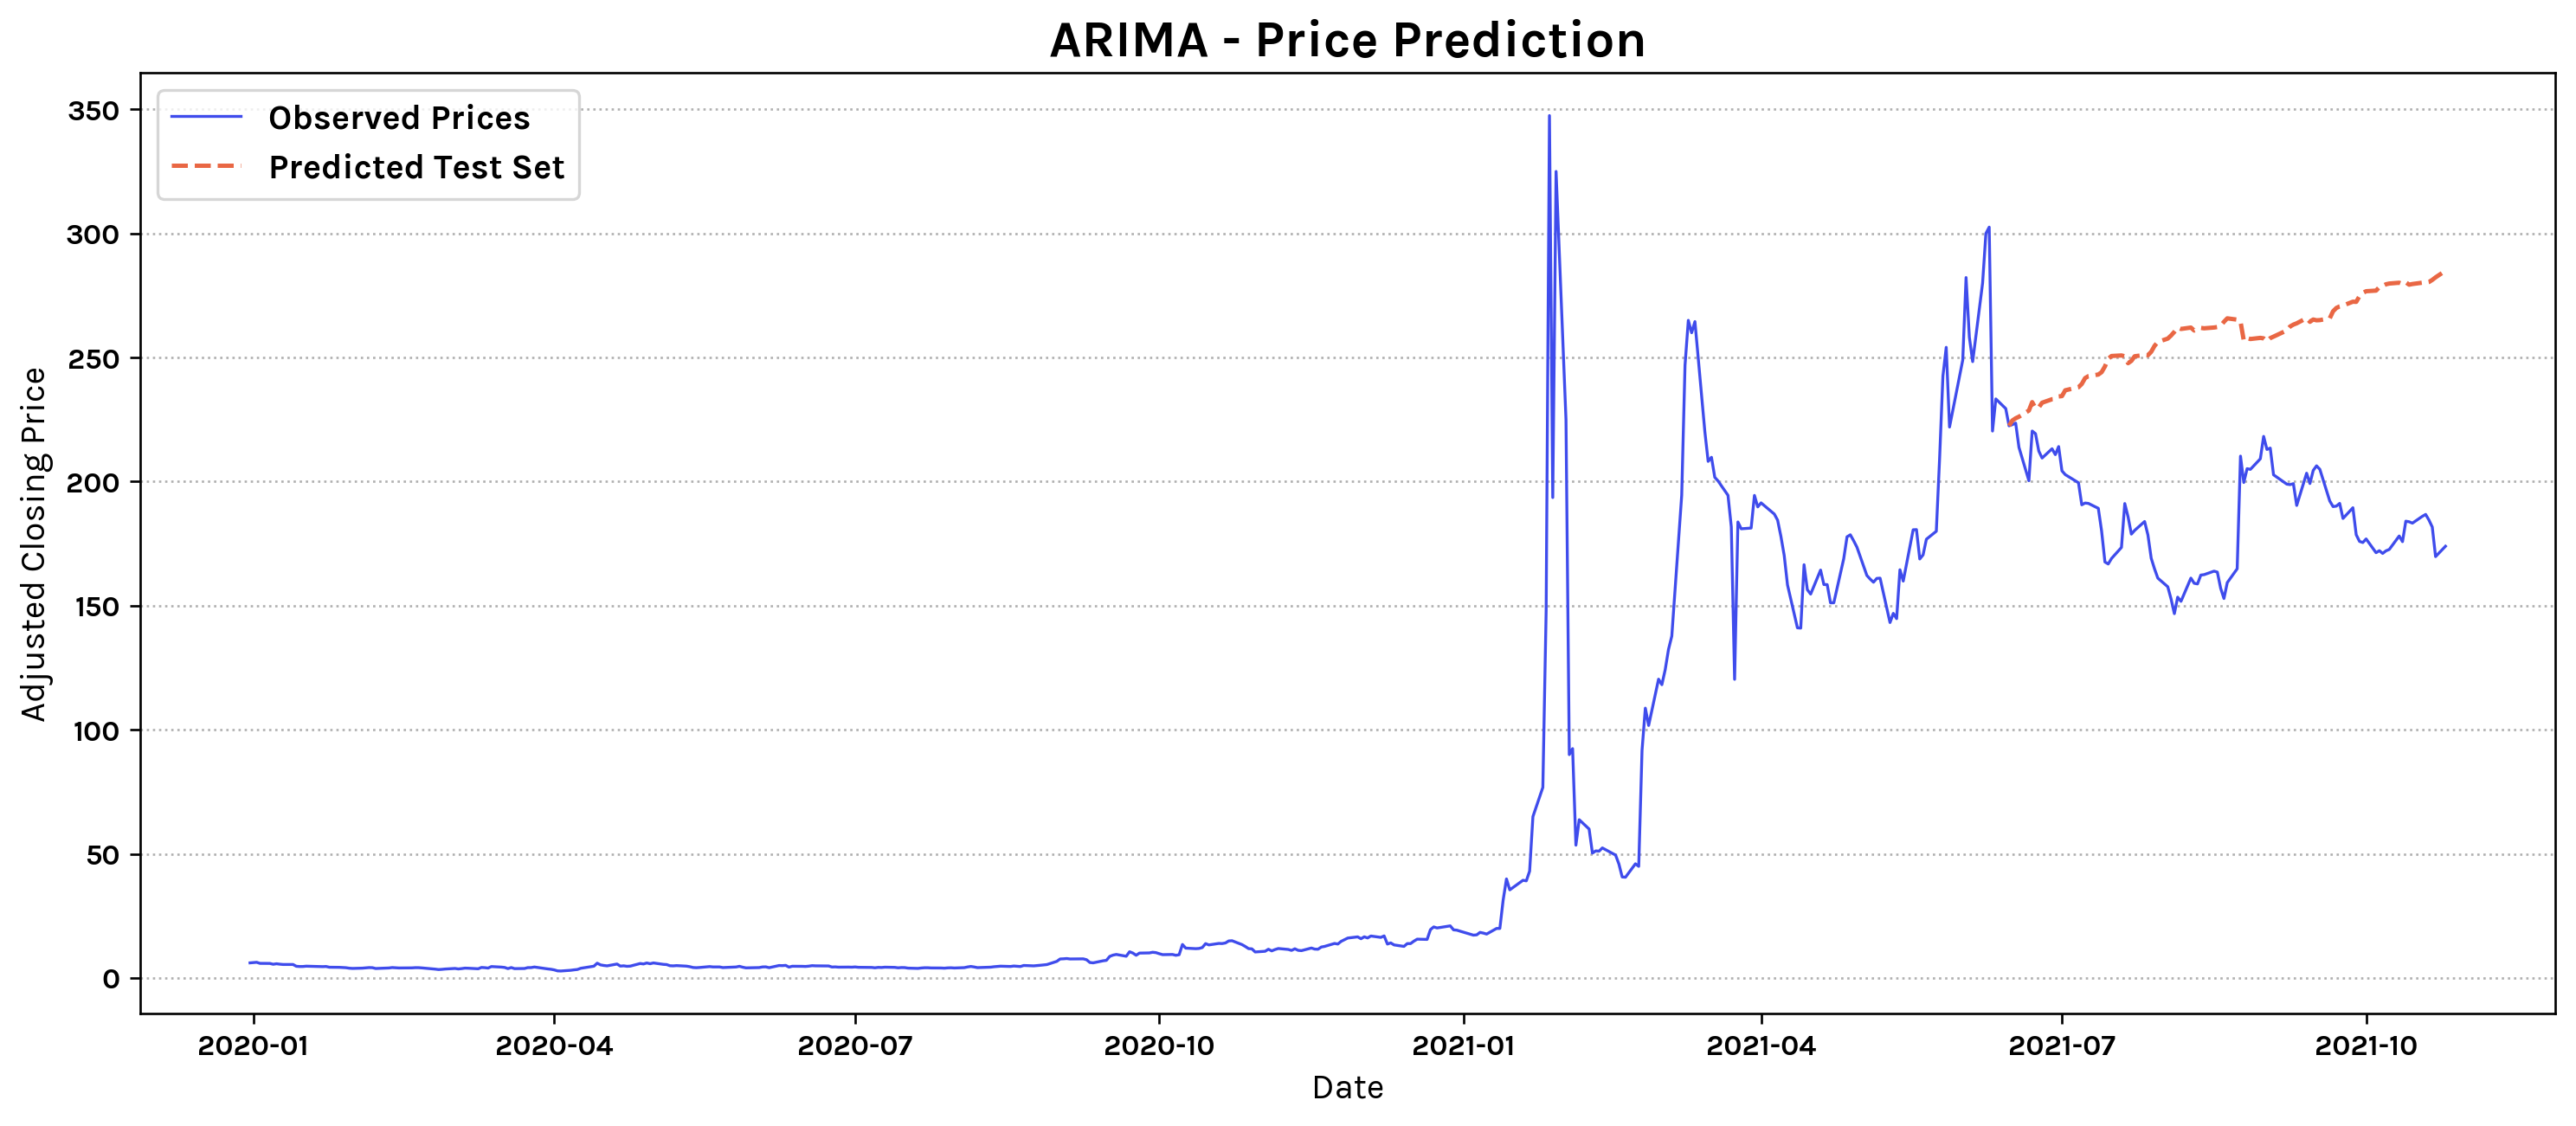

In [29]:
plt.rcParams['font.sans-serif'] = "Karla"
plt.rcParams["font.weight"] = "bold"

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=240)

x = ts.Date
plt.plot(x, ts["Adj Close"], color = "#3F4CEC", linewidth = 1, label = "Observed Prices")
plt.plot(x, testPredictPlot, color = "#E96744", linestyle='dashed', label = "Predicted Test Set")
plt.legend(loc="upper left", prop={'size': 12})
plt.ylabel("Adjusted Closing Price", fontsize = 12)
plt.grid(axis = "y", linestyle = "dotted")
plt.xlabel("Date", fontsize = 12)
plt.title("ARIMA - Price Prediction", fontsize = 18, weight = "bold")
plt.show()